<a href="https://colab.research.google.com/github/shahchayan9/Dimensionality-Reduction/blob/main/FactorAnalysis(scikitLearn).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Factor Analysis: Understanding Dimensionality Reduction

Often, the datasets we use for data analysis and Machine Learning tasks have several variables. Using such datasets as they are can damage model performance and significantly increase training time or make it extremely difficult to analyze data and get insights from it.

**Exploratory Factor Analysis (FA)** is a dimensionality reduction technique that attempts to:
- Group intercorrelated variables together
- Produce interpretable outputs

In this notebook, we are going to talk about the general idea behind factor analysis, and understand it through a hands-on approach using the **Student Performance Data Set** to classify whether or not a student will succeed in his math class.

# Dimensionality Reduction with Factor Analysis applied to the Student Performance Data Set

In this notebook, we are going to dive into the exploratory factor analysis technique. This is a dimensionality reduction technique that groups correlated variables that are assumed to share the same kind of information which would be useful to explain the outcomes of the dataset.

The results obtained using Factor Analysis (FA) were compared to the results without factor Analysis and with the original results from the [dataset paper](http://www3.dsi.uminho.pt/pcortez/student.pdf).

Results for Binary Classification (without using the variables G1 and G2), i.e., predicting if student will succeed or not:

- G3 > 10: pass
- G3 < 10: fail

| Setup           | Model               | Accuracy |
|-----------------|---------------------|----------|
| With Factor Analysis         | Logistic Regression | 0.785 |
| Without Factor Analysis      | Logistic Regression | 0.646 |
| Original Results| SVM | 0.706 |

Results for Multi-Class Classification (without using the variables G1 and G2), based on the  5-level classification based on Erasmus grade conversion system:
- 16-20: very good
- 14-15: good
- 12-13: satisfactory
- 10-11: sufficient
- 0-9 : fail

| Setup           | Model               | Accuracy |
|-----------------|---------------------|----------|
| With Factor Analysis         | SGD | 0.367 |
| Without Factor Analysis      | AdaBoost | 0.380 |
| Original Results| Random Forest | 0.335 |

The notebook is divided as follows:

1. Load Data
2. Preprocessing \
  2.1 Feature Selection \
  2.2 Feature Encoding \
  2.3 Assumptions
3. Exploratory Factor analysis \
  3.1 Choosing the number of factors \
  3.2 Analysis \
  3.3 Model
  
**References**:

Dataset Paper: [Reference 0](http://www3.dsi.uminho.pt/pcortez/student.pdf) \
Assumptions: [Reference 1](https://en.wikiversity.org/wiki/Exploratory_factor_analysis/Assumptions), [Reference 2](https://en.wikiversity.org/wiki/Survey_research_and_design_in_psychology/Lectures/Exploratory_factor_analysis/Notes#Assumption_testing) \
Steps of a factor analysis: [Reference 3](https://www.let.rug.nl/nerbonne/teach/rema-stats-meth-seminar/Factor-Analysis-Kootstra-04.PDF) \
Concepts and Theory: [Reference 4](https://hal.archives-ouvertes.fr/hal-02557344/document) \
Model package: [factor_analyzer](https://factor-analyzer.readthedocs.io/en/latest/factor_analyzer.html#factor-analyzer-analyze-module)

![Exploratory Factor Analysis](https://miro.medium.com/v2/resize:fit:828/format:webp/1*2xiBsqtes77-Tz1JZJRbkA.png)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
!pip install factor_analyzer

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42568 sha256=7ee3a6ab0f593703f634276a4edc3c2c57750e6514bdb33c1974ed3484cdc621
  Stored in directory: /root/.cache/pip/wheels/24/59/82/6493618e30ed1cb7a013b9e1b0c9e17de80b04dfcef4ba8a4d
Successfully built factor_analyzer


## 1. Load Data

In [ ]:
# prompt: pull dataset from https://www.kaggle.com/code/alexandrehsd/binary-multiclass-classification-factor-analysis/input

!pip install kaggle

# Assuming you have your Kaggle API key configured correctly.
# If not, follow the instructions at https://www.kaggle.com/docs/api
!kaggle datasets download -d dipam7/student-grade-prediction

!unzip student-grade-prediction.zip -d student-grade-prediction

Dataset URL: https://www.kaggle.com/datasets/dipam7/student-grade-prediction
License(s): unknown
  0% 0.00/7.16k [00:00<?, ?B/s]
100% 7.16k/7.16k [00:00<00:00, 15.4MB/s]
Archive:  student-grade-prediction.zip
  inflating: student-grade-prediction/student-mat.csv  


In [ ]:
DATASET = "./student-grade-prediction/student-mat.csv"
dataset =  pd.read_csv(DATASET, sep=",")

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

## 2. Preprocessing

### 2.1 Feature Selection

Initially, we must decide which variables we are going to use. We are not making distinction among schools. Therefore the variable school will be dropped out.

In [ ]:
dataset["school"].value_counts()

,count
school,
GP,349
MS,46


In [ ]:
drop_features = ["school"]

data = dataset.drop(labels=drop_features, axis=1)

### 2.2 Feature Encoding

Here we are going to use two techniques to encode the categorical variables:

1. (Dummy) One Hot Encoding
2. Ordinal Encoding

#### 2.2.1 Ordinal Encoding

In [ ]:
def ordinal_encode(series, categories):
  encoder = OrdinalEncoder(categories=categories, dtype=np.int64)
  return encoder.fit_transform(series.values.reshape(-1, 1))

In [ ]:
categories_ordenc = {"sex": [["F", "M"]],
                     "address": [["R", "U"]],
                     "famsize": [["LE3", "GT3"]],
                     "Pstatus": [['A', 'T']],
                     "schoolsup": [["no", "yes"]],
                     "famsup": [["no", "yes"]],
                     "paid": [["no", "yes"]],
                     "activities": [["no", "yes"]],
                     "nursery": [["no", "yes"]],
                     "higher": [["no", "yes"]],
                     "internet": [["no", "yes"]],
                     "romantic": [["no", "yes"]],
                     }

for column, category in categories_ordenc.items():
  data[column] = ordinal_encode(data[column], category)

#### 2.2.2 (Dummy) One Hot Encoding

In [ ]:
def onehot_encode(data, column, categories):
  encoder = OneHotEncoder(categories=categories, drop="first", sparse_output=False, dtype=np.int64)
  encoded_features = encoder.fit_transform(data[column].values.reshape(-1, 1))
  encoder.transform(data[column].values.reshape(-1, 1))

  data = data.drop(labels=column, axis=1)

  for j, category in enumerate(categories[0][1:]):
    category_column_name = "{}_{}".format(column, category)
    data[category_column_name] = encoded_features[:, j]

  return data

In [ ]:
categories_hotenc = {"Fjob": [["other", "teacher", "health", "services", 'at_home']],
                     "Mjob": [["other", "teacher", "health", "services", 'at_home']],
                     "reason": [["other", "home", "reputation", "course"]],
                     "guardian": [["other", "mother", "father"]]}

for column, category in categories_hotenc.items():
  data = onehot_encode(data, column, category)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   sex                395 non-null    int64
 1   age                395 non-null    int64
 2   address            395 non-null    int64
 3   famsize            395 non-null    int64
 4   Pstatus            395 non-null    int64
 5   Medu               395 non-null    int64
 6   Fedu               395 non-null    int64
 7   traveltime         395 non-null    int64
 8   studytime          395 non-null    int64
 9   failures           395 non-null    int64
 10  schoolsup          395 non-null    int64
 11  famsup             395 non-null    int64
 12  paid               395 non-null    int64
 13  activities         395 non-null    int64
 14  nursery            395 non-null    int64
 15  higher             395 non-null    int64
 16  internet           395 non-null    int64
 17  romantic        

In [ ]:
X = data.drop(labels=["G1", "G2", "G3"], axis=1)
y = data[["G3"]]

### 2.3 Assumptions

To proceed with Factor Analysis, the data must be suited for the model. We are going to check the following characteristics:

2.3.1 Outliers \
2.3.2 Sample Size \
2.3.3 Linear Relations \
2.3.4 Normality \
2.3.5 Factorability

#### 2.3.1 Outliers

To perform outlier detection, we are going to employ the Z-Score method because it is the simplest one.

In [ ]:
def detect_outlier(df):

  flag_outlier = False

  for feature in df:
    column = df[feature]
    mean = np.mean(column)
    std = np.std(column)
    z_scores = (column - mean) / std
    outliers = np.abs(z_scores) > 3

    n_outliers = sum(outliers)
    if n_outliers > 0:
      print("{} has {} outliers".format(column, n_outliers))
      flag_outlier = True

    if ~flag_outlier:
      print("The dataset has no outliers.")

    return None

detect_outlier(X)

The dataset has no outliers.


#### 2.3.2 Sample size

Typical guidelines for factor analysis sample size requirements reported in the research method literature are:

A Total N > 200 is recommended. Comrey and Lee (1992) provide this description of total sample sizes' adequacy for factor analysis:

50 = very poor,
100 = poor,
200 = fair,
300 = good,
500 = very good
1000+ = excellent

Min/Ideal sample size based on variable:factor ratio

Min. N > 5 cases per variable (item)
e.g., if I have 30 variables, I should have at least 150 cases (i.e., 1:5)

Ideal N > 20 cases per variable
e.g., if I have 30 variables, I would ideally have at least 600 cases (1:20)

In [ ]:
# Number of variables
len(X.columns)

38

Ideally we should have 38*20 = 760 samples but considering that the number of variables raised considerably because of the one hot encoding strategy. Aggregating all new variables originated from the one hot encoding technique, we would have 29 variables. Thus, the number of ideal samples would shrink to 580.

We have 395 samples, which corresponds to almost 70% of the ideal amount of variables. However, the minimum ratio of variables:samples is 1:5. Since we have 38 variables, the minimum number of samples is 190.

Therefore, we are not in the ideal setup, but the data fullfil the minimum size requirement to proceed with the factor analysis.

#### 2.3.3 Linear relations

Since all but one of our variables (absences) are discrete and have few instances, it does not make sense to check for linear relations. Therefore, this point is automatically satisfied.

#### 2.3.4 Normality

<ipython-input-16-4301b51a3a1f>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  X.hist(ax=ax)


[]

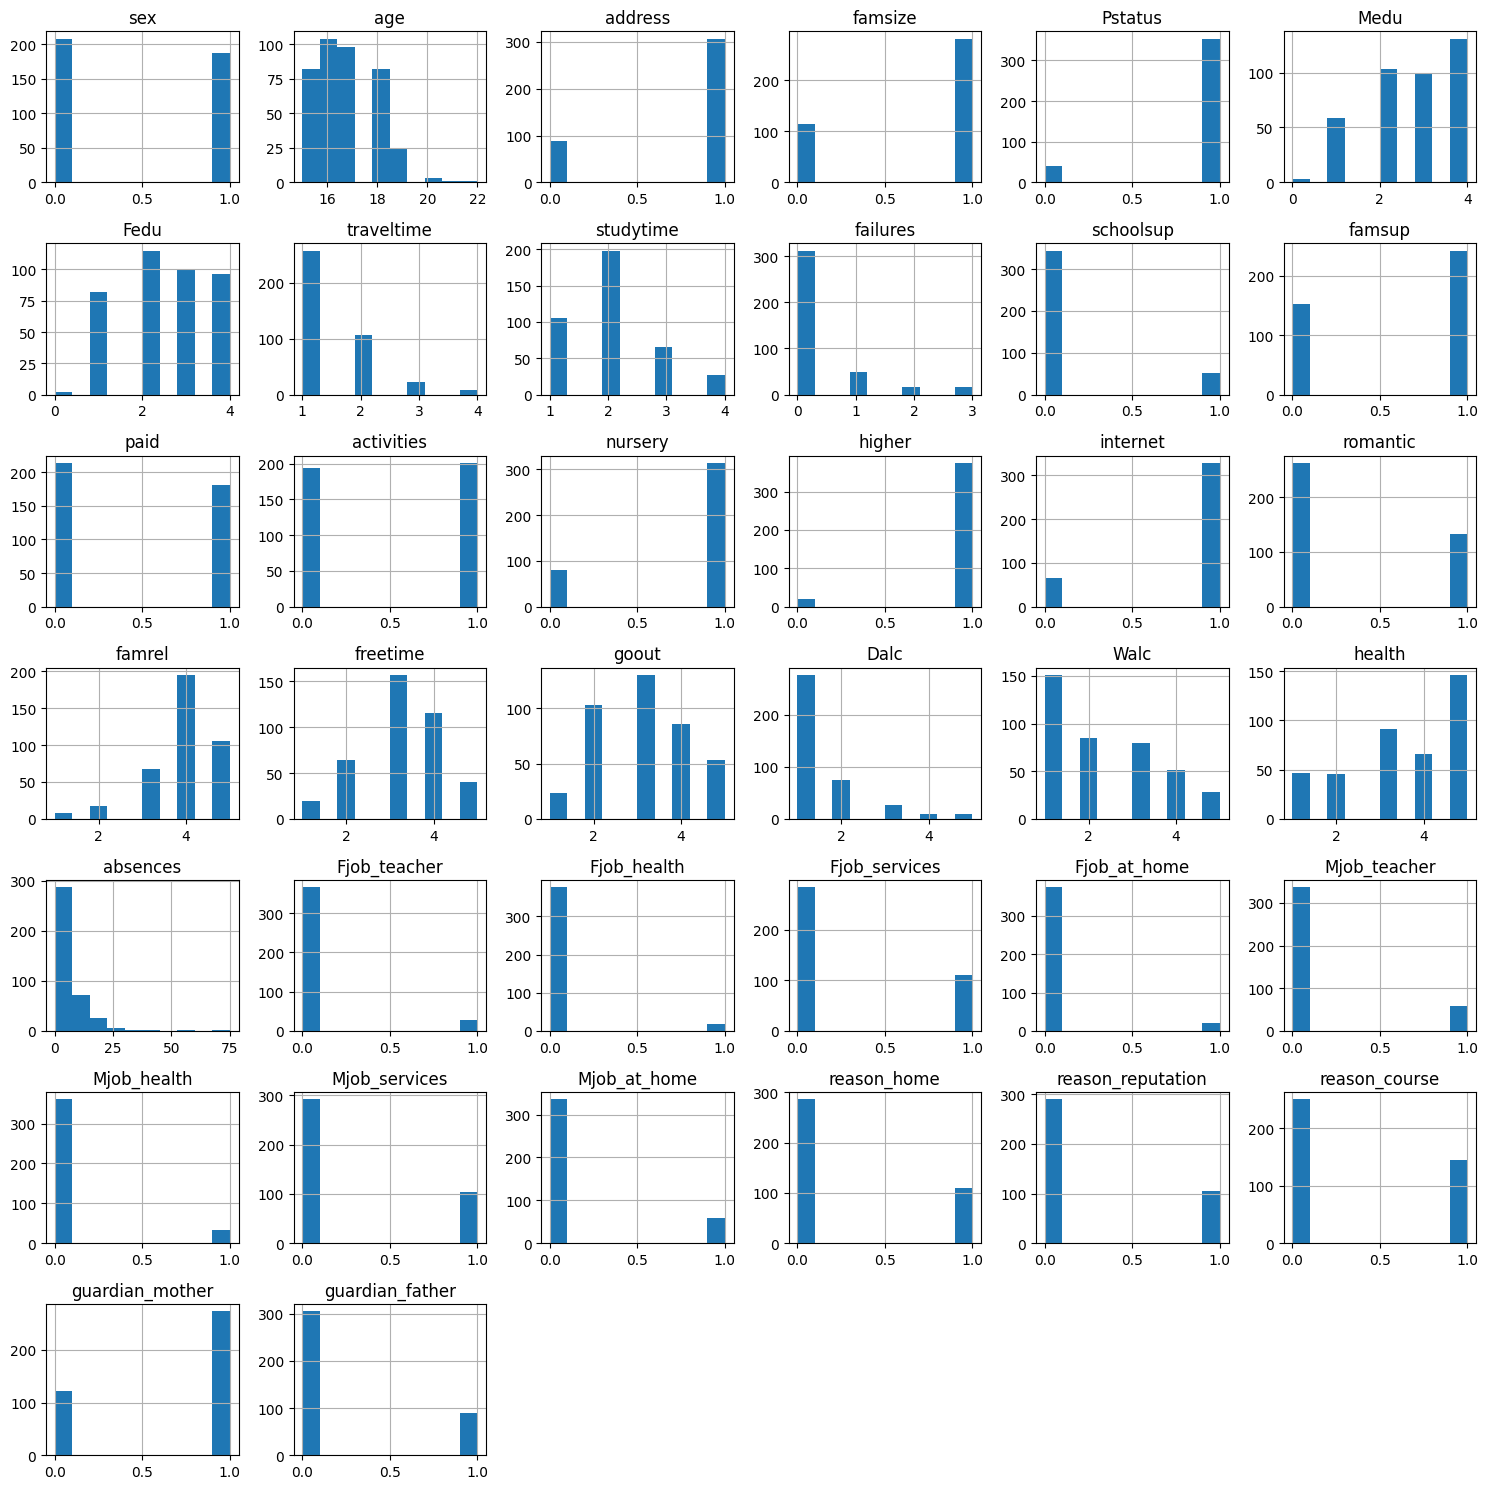

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))
X.hist(ax=ax)

plt.tight_layout()
plt.plot()

#### 2.3.5 Factorability

Factorability is the assumption that there are at least some correlations amongst the variables so that coherent factors can be identified. Basically, there should be some degree of collinearity among the variables but not an extreme degree or singularity among the variables. Factorability means “can we found the factors in the dataset?”.

There are some ways of measure factorability:

1. Inter-item correlations (correlation matrix) - are there at least several small-moderate sized correlations e.g., > .3?
2. Measures of sampling adequacy (MSAs):
  - Kaiser-Meyer-Olkin (KMO) (should be > ~.5 or .6) and
  - Bartlett's test of sphericity (should be significant)

We are going to explore the second way soon in the notebook.

##### 2.3.5.1 Inter-item correlatins (correlation Matrix)

In this method, we investigate the correlation to matrix to verify that we don't have extreme values of correlation and neither have 0 correlations amongst the values outside the main diagonal of the matrix.

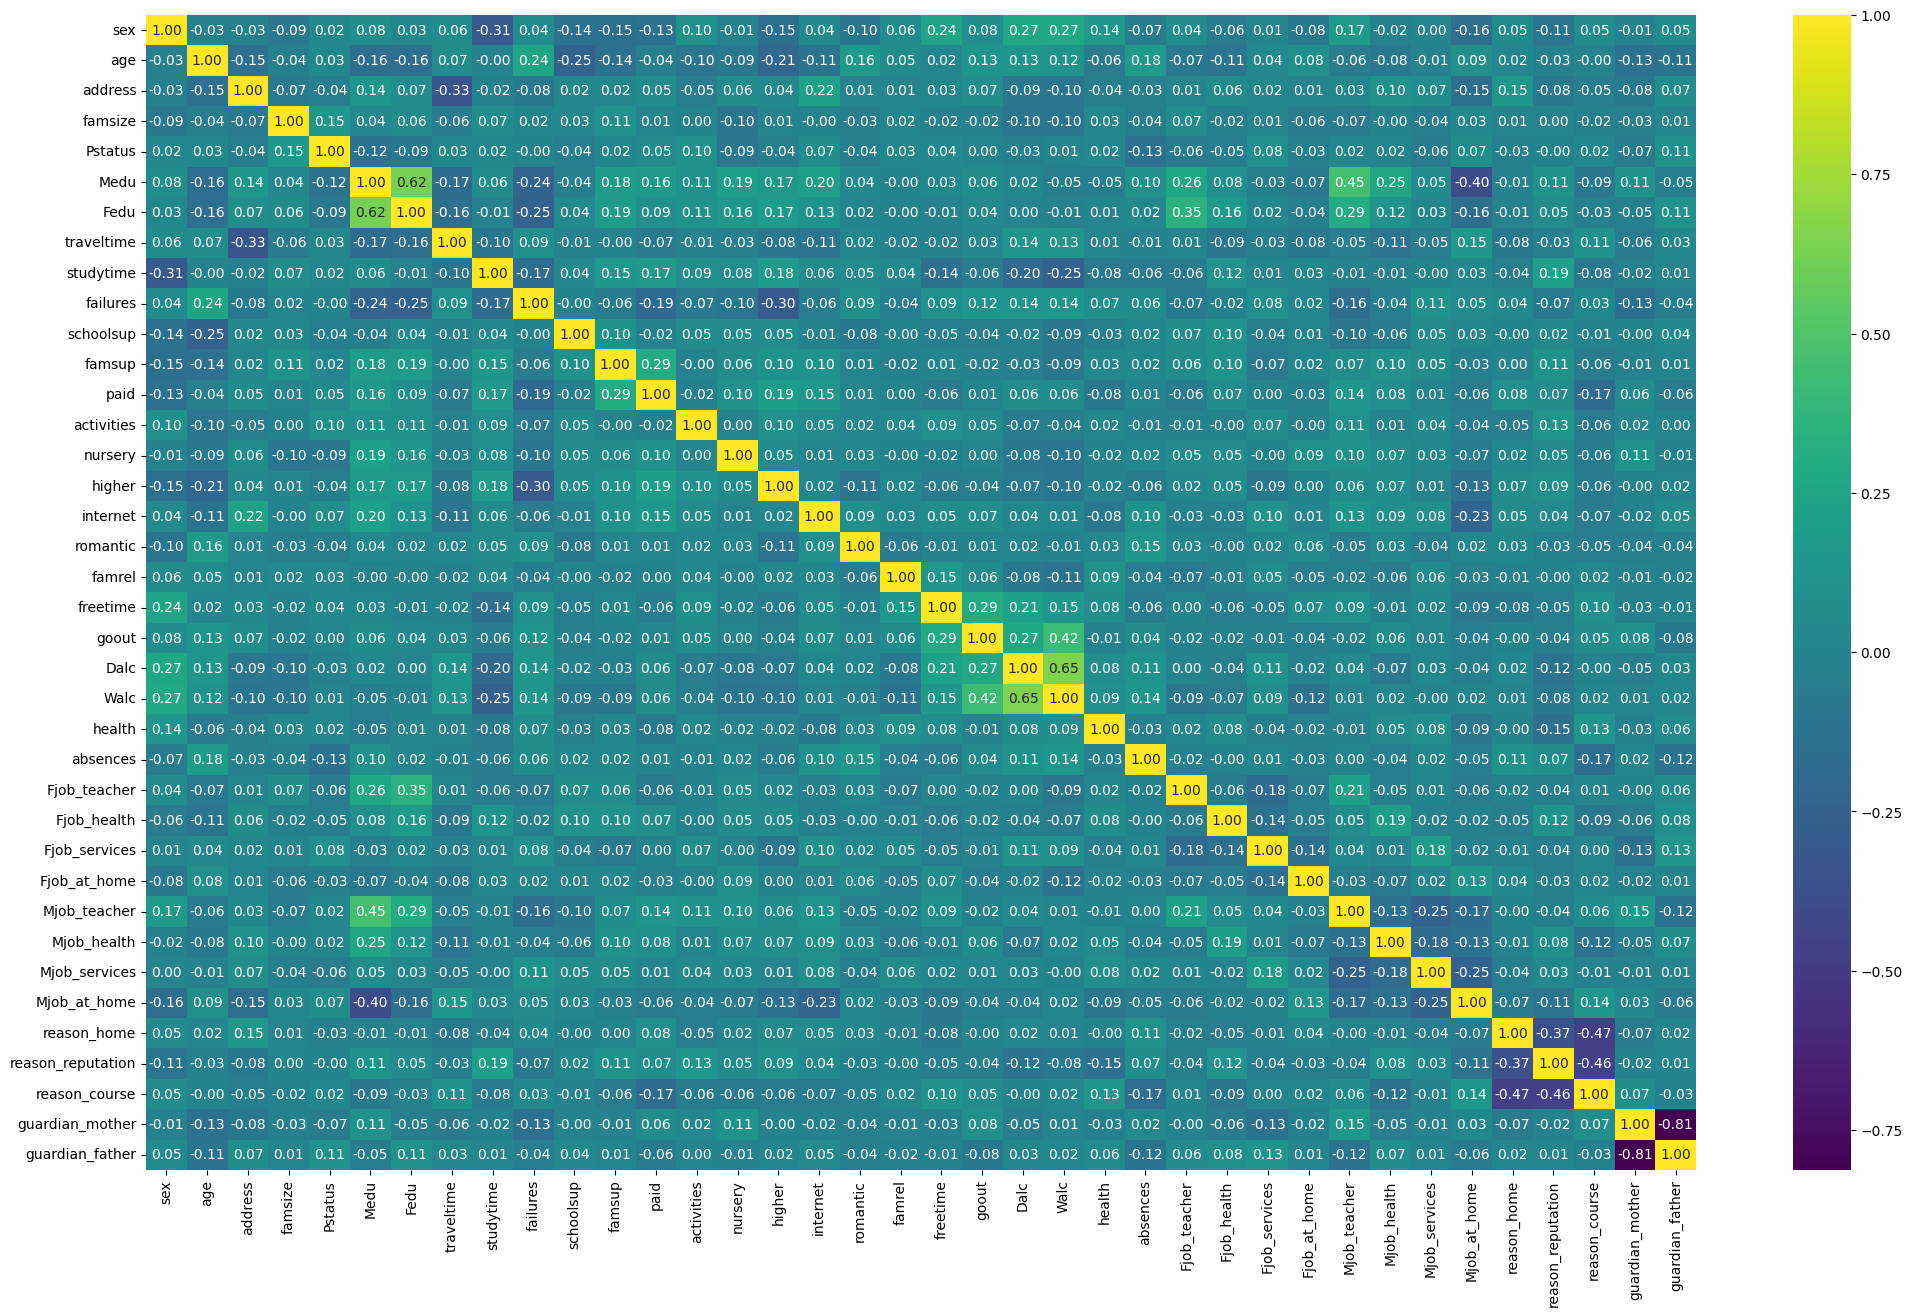

In [ ]:
fig, ax = plt.subplots(figsize=(25, 15))

ax = sns.heatmap(X.corr(), annot=True, fmt=".2f", cmap="viridis", ax=ax)
plt.show()

We can see from the correlation matrix that we have several small-moderate sized correlations, e.g. > 0.3 or < -0.3. Thus, we can proceed to another methodology of data quality assessment.

##### 2.3.5.2 Measures of Sampling Adequacy (MSAs) Tests

Sampling adequacy provides the researcher with information regarding the grouping of survey items. Grouping items into a set of interpretable factors can better explain the constructs under investigation. Measures of sampling adequacy evaluate how strongly an item is correlated with other items in the EFA correlation matrix.

**Suitability of Data - Bartlett’s Test**

Bartlett’s test of Sphericity provides a chi-square output that must be significant. It indicates the matrix is not an identity matrix and accordingly it should be significant ($p < .05$) for factor analysis to be suitable.

In [ ]:
chi_square_value, p_value = calculate_bartlett_sphericity(X)
chi_square_value, p_value

(3338.7570145095465, 0.0)

In Bartlett’s test, the p-value is 0. The test was statistically significant, indicating that the observed correlation matrix is not an identity matrix. What is in fact what we verified earlier.

**Sampling Adequacy - Kaiser-Meyer-Olkin (KMO) test**

The KMO test measures the suitability of data for factor analysis. It determines the adequacy for each observed variable and for the complete model. KMO estimates the proportion of variance among all the observed variables. Lower proportion is more suitable for factor analysis. KMO values range between 0 and 1. The value of KMO less than 0.6 is considered inadequate.

In [ ]:
kmo_all, kmo_model = calculate_kmo(X)

print("Overall KMO = {:.3f}".format(kmo_model))
print("KMO per feature:\n{}".format(kmo_all.round(3)))

Overall KMO = 0.491
KMO per feature:
[0.694 0.52  0.578 0.436 0.565 0.597 0.619 0.643 0.639 0.644 0.545 0.64
 0.648 0.559 0.622 0.647 0.63  0.464 0.436 0.608 0.58  0.604 0.596 0.494
 0.539 0.477 0.384 0.316 0.386 0.425 0.302 0.269 0.655 0.255 0.306 0.321
 0.438 0.442]


/usr/local/lib/python3.10/dist-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


In [ ]:
# Variables considered adequate by the KMO test
kmo_passed = list(X.columns[kmo_all >= 0.5])
kmo_passed

['sex',
 'age',
 'address',
 'Pstatus',
 'Medu',
 'Fedu',
 'traveltime',
 'studytime',
 'failures',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'freetime',
 'goout',
 'Dalc',
 'Walc',
 'absences',
 'Mjob_at_home']

In [ ]:
# Variables considered inadequate by the KMO test
kmo_failed = list(X.columns[kmo_all < 0.5])
kmo_failed

['famsize',
 'romantic',
 'famrel',
 'health',
 'Fjob_teacher',
 'Fjob_health',
 'Fjob_services',
 'Fjob_at_home',
 'Mjob_teacher',
 'Mjob_health',
 'Mjob_services',
 'reason_home',
 'reason_reputation',
 'reason_course',
 'guardian_mother',
 'guardian_father']

Unfortunately, the overall KMO value was 0.489, which is no good. The minimum viable value is 0.5. However, we can try to improve this metric by removing some variables that failed the KMO test. Considering that the variables that failed the KMO test are those built using one hot encoding. Let's remove them and re-compute the KMO test values.

In [ ]:
kmo_passed = list(X.columns[kmo_all >= 0.5])
X_kmo = X[kmo_passed]

kmo_all, kmo_model = calculate_kmo(X_kmo)

print("Overall KMO = {:.3f}".format(kmo_model))
print("KMO per feature:\n{}".format(kmo_all.round(3)))

Overall KMO = 0.640
KMO per feature:
[0.676 0.625 0.615 0.561 0.635 0.613 0.68  0.68  0.761 0.479 0.651 0.627
 0.551 0.762 0.739 0.671 0.64  0.602 0.657 0.617 0.469 0.642]


/usr/local/lib/python3.10/dist-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


Fantastic, we managed to got a reasonable value of 0.638 in the KMO test. Let's use this subset of variables and proceed to the Exploratory Factor Analysis

In [ ]:
X = X_kmo.copy()

## 3. Exploratory Factor Analysis

In [ ]:
def train_factor_model(dataset, number_of_factors, rotation="varimax"):
  factor_model = FactorAnalyzer(n_factors=number_of_factors, rotation=rotation)
  factor_model.fit(dataset)

  return factor_model

In [ ]:
def scree_plot(eigenvalues, n_columns):
  plt.style.use("fivethirtyeight")
  # Create scree plot using matplotlib
  fig, ax = plt.subplots(figsize=(10, 6))

  ax.scatter(range(1, n_columns + 1), eigenvalues, s=50)
  ax.plot(range(1, n_columns + 1), eigenvalues)

  ax.set_title('Scree Plot')
  ax.set_xlabel('# Factors')
  ax.set_ylabel('Eigenvalues')

  ax.grid(False)

  ax.axhline(y=1, linestyle="--", color="grey", linewidth=1)
  # plt.savefig("scree_plot.png", transparent=True, dpi=600)
  plt.show()

In [ ]:
def loadings_plot(loadings, variables):
  # Create loadings plot using matplotlib
  fig, ax = plt.subplots(figsize=(15, 5))

  image = ax.matshow(loadings, cmap="hot")

  n_factors = loadings.shape[1]
  factors = ["Factor{}".format(index) for index in range(n_factors)]

  ax.set_yticklabels([""] + variables, fontsize=10)
  ax.set_xticklabels([""] + factors, rotation="vertical", fontsize=10)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.grid(False)

  plt.colorbar(image)
  plt.tight_layout()
  plt.show()

In [ ]:
factor_model = train_factor_model(X, len(X.columns), rotation="oblimin")

#### 3.1 Choosing the Number of Factors

In [ ]:
eigenvalues, common_factor_eigenvalues = factor_model.get_eigenvalues()

In [ ]:
eigenvalues

array([2.88143473, 2.36397703, 1.49455521, 1.37878752, 1.31015964,
       1.19688253, 1.09258507, 1.05011049, 1.01469519, 0.90518769,
       0.89645237, 0.78506175, 0.7736879 , 0.75093821, 0.71202434,
       0.61761662, 0.60398935, 0.57106196, 0.52453711, 0.48659866,
       0.31362068, 0.27603595])

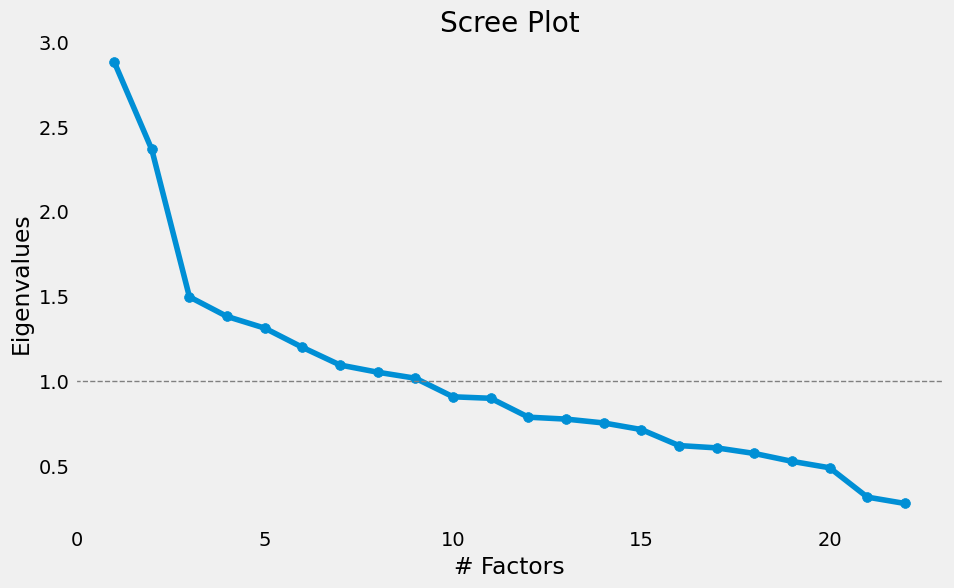

In [ ]:
n_columns = len(X.columns)
scree_plot(eigenvalues, n_columns=n_columns)

Using Kaiser Criterion, we must choose just 9 factors to model the variability of the dataset.

In [ ]:
number_of_factors = sum(eigenvalues > 1)
factor_model = train_factor_model(X, number_of_factors, rotation="promax")

#### 3.2 Analysis

<ipython-input-26-8b1479f7c88e>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([""] + variables, fontsize=10)
<ipython-input-26-8b1479f7c88e>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + factors, rotation="vertical", fontsize=10)


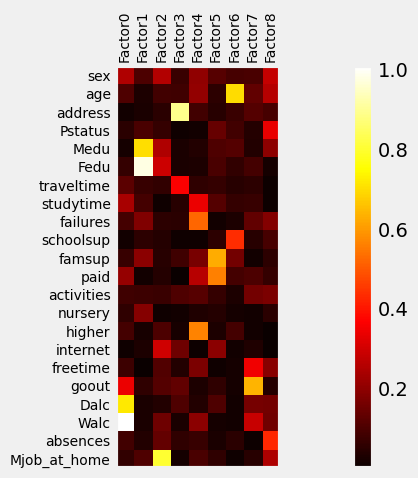

In [ ]:
loadings = factor_model.loadings_
loadings_abs = np.abs(loadings)

columns = X.columns.tolist()
loadings_plot(loadings_abs, columns)

In [ ]:
n_factors = loadings.shape[1]
factors_list = ["Factor{}".format(index) for index in range(n_factors)]
factors = {}.fromkeys(factors_list, None)
for key in factors:
  factors[key] = []

argsmax = loadings_abs.argmax(axis=1)
for argmax, column in zip(argsmax, columns):
  factors[factors_list[argmax]].append(column)

In [ ]:
factors

{'Factor0': ['Dalc', 'Walc'],
 'Factor1': ['Medu', 'Fedu', 'nursery'],
 'Factor2': ['internet', 'Mjob_at_home'],
 'Factor3': ['address', 'traveltime'],
 'Factor4': ['studytime', 'failures', 'higher'],
 'Factor5': ['famsup', 'paid'],
 'Factor6': ['age', 'schoolsup'],
 'Factor7': ['freetime', 'goout'],
 'Factor8': ['sex', 'Pstatus', 'activities', 'absences']}

The factors can be translated into:

Factor 0: Alcohol consumption \
Factor 1: Parents education \
Factor 2: Home Infrastructure \
Factor 3: Distance to School \
Factor 4: Commitment \
Factor 5: Family Educational Financial Incentive \
Factor 6: Extra classes \
Factor 7: Sociability \
Factor 8: Extracurricular activities and attendance

### 3.3 Model

We have 3 possible approaches to the problem:

- Binary classification \
G3 > 10: pass \
G3 < 10: fail

- 5-level classification based on Erasmus grade conversion system \
16-20: very good \
14-15: good \
12-13: satisfactory \
10-11: sufficient \
0-9 : fail

- Regression (Predicting G3) \
We will not do this one.

In [ ]:
# Create target variable for binary and multiclass classification
seed = 42

X_latent = factor_model.transform(X)
y_binary = np.array((y["G3"] > 10) + 0)

multiclass_categories = ["poor", "unsatisfactory", "satisfactory", "good", "very good"]
y_multiclass = []
for grade in y["G3"]:
  if grade < 10:
    y_multiclass.append(0)
  elif grade < 12:
    y_multiclass.append(1)
  elif grade < 14:
    y_multiclass.append(2)
  elif grade < 16:
    y_multiclass.append(3)
  elif grade <= 20:
    y_multiclass.append(4)

y_multiclass = np.array(y_multiclass)

In [ ]:
def train(X, y, grid_params, seed):

  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                      test_size=0.2,
                                                      random_state=seed,
                                                      stratify=y)

  # The models dict has same keys as grid_params
  # pointing to the grid search of each classifier
  models = {
      "SGD": SGDClassifier(),
      "Logistic Regression": LogisticRegression(),
      "Random Forest": RandomForestClassifier(),
      "AdaBoost": AdaBoostClassifier(),
      "GradientBoost": GradientBoostingClassifier()
  }

  # store best estimators
  best_estimators = dict.fromkeys(models.keys())

  for model_name in models:
    base_clf = models[model_name]
    params = grid_params[model_name]

    print("[INFO] Performing Grid-Search CV ---- {}".format(model_name))
    model = GridSearchCV(base_clf, params, scoring='accuracy', cv=5, n_jobs=-1,
                         verbose=0)

    model.fit(X_train, y_train)
    best_estimators[model_name] = model.best_estimator_

  return best_estimators, X_test, y_test

In [ ]:
def evaluate_binary(models, X_test, y_test):

  results = pd.DataFrame(columns=["accuracy", "Precision", "Recall", "F1 Score"],
                         index=models.keys())

  for model_name, model in models.items():
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.loc[model_name, :] = accuracy, precision, recall, f1

  return results

In [ ]:
def evaluate_multiclass(models, X_test, y_test):
  results = pd.DataFrame(columns=["Overall Accuracy"], index=models.keys())

  for model_name, model in models.items():
    n_samples = len(y_test)
    y_pred = model.predict(X_test)

    overall_accuracy = np.sum(y_pred == y_test) / n_samples
    results.loc[model_name, :] = overall_accuracy

  return results

In [ ]:
# choose best models based on accuracy
def select_binary_model(models, X_test, y_test):
  best_accuracy = -1
  best_model = ""
  for model_name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    if accuracy > best_accuracy:
      best_accuracy = accuracy
      best_model = model_name

  print("{}\naccuracy = {:.4f}".format(best_model, best_accuracy))
  return models[best_model]

In [ ]:
def select_multiclass_model(models, X_test, y_test):
  best_overall_accuracy = -1
  best_model = ""
  n_samples = len(y_test)

  for model_name, model in models.items():
    y_pred = model.predict(X_test)

    overall_accuracy = np.sum(y_pred == y_test) / n_samples

    if overall_accuracy > best_overall_accuracy:
      best_overall_accuracy = overall_accuracy
      best_model = model_name

  print("{}\nOverall accuracy = {:.4f}".format(best_model, best_overall_accuracy))
  return models[best_model]

#### 3.3.1 Binary Classification

In [ ]:
grid_params_binary = {
    "SGD": {
        "penalty": ["l1", "l2", "elasticnet"],
        "alpha": np.linspace(1e-5, 1e-3, 5),
        "learning_rate": ["optimal", "invscaling", "adaptive"],
        "eta0": np.linspace(1e-4, 1e-1, 5)
    },
    "Logistic Regression": {
        "penalty": ["l1", "l2"],
        "C": [1, 2, 4, 5],
        "solver": ["liblinear"]
    },
    "Random Forest": {
        "criterion": ["gini", "entropy"],
        "max_depth": np.linspace(3, 12, 4, dtype=np.int64),
        "min_samples_split": np.linspace(0.1, 0.5, 6),
        "min_samples_leaf": np.linspace(0.1, 0.5, 6),
        "max_features":["log2","sqrt"]
    },
    "AdaBoost": {
        "estimator": [DecisionTreeClassifier(max_depth=1),
                           DecisionTreeClassifier(max_depth=2),
                           DecisionTreeClassifier(max_depth=3)],
        "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1],
        "n_estimators": np.linspace(20, 80, 4, dtype=np.int64),
    },
    "GradientBoost": {
        "loss":["log_loss"],
        "learning_rate": [0.01, 0.025, 0.05, 0.075],
        "min_samples_split": np.linspace(0.1, 0.5, 5),
        "min_samples_leaf": np.linspace(0.1, 0.5, 5),
        "max_depth":[3, 5, 8],
        "max_features":["log2","sqrt"],
        "criterion": ["friedman_mse"],
        "subsample":[0.5, 0.618, 0.85],
        "n_estimators":[5, 10, 15]
    }
}

In [ ]:
# Train and evaluate binary model with factor analysis (latent) variables
estimators_binary_latent, X_test_latent, y_test_binary = train(X_latent,
                                                               y_binary,
                                                               grid_params_binary,
                                                               seed)

evaluate_binary(estimators_binary_latent, X_test_latent, y_test_binary)

[INFO] Performing Grid-Search CV ---- SGD
[INFO] Performing Grid-Search CV ---- Logistic Regression
[INFO] Performing Grid-Search CV ---- Random Forest


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[INFO] Performing Grid-Search CV ---- AdaBoost


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[INFO] Performing Grid-Search CV ---- GradientBoost


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


,accuracy,Precision,Recall,F1 Score
SGD,0.607595,0.648649,0.571429,0.607595
Logistic Regression,0.78481,0.804878,0.785714,0.795181
Random Forest,0.620253,0.65,0.619048,0.634146
AdaBoost,0.696203,0.6875,0.785714,0.733333
GradientBoost,0.594937,0.6,0.714286,0.652174


In [ ]:
# Train and evaluate binary model with the original variables (without factor analysis)
estimators_binary, X_test, y_test_binary = train(X, y_binary,
                                                 grid_params_binary,
                                                 seed)

evaluate_binary(estimators_binary, X_test, y_test_binary)

[INFO] Performing Grid-Search CV ---- SGD
[INFO] Performing Grid-Search CV ---- Logistic Regression
[INFO] Performing Grid-Search CV ---- Random Forest


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[INFO] Performing Grid-Search CV ---- AdaBoost


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[INFO] Performing Grid-Search CV ---- GradientBoost


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


,accuracy,Precision,Recall,F1 Score
SGD,0.594937,0.592593,0.761905,0.666667
Logistic Regression,0.64557,0.645833,0.738095,0.688889
Random Forest,0.607595,0.622222,0.666667,0.643678
AdaBoost,0.556962,0.568627,0.690476,0.623656
GradientBoost,0.632911,0.638298,0.714286,0.674157


In [ ]:
best_latent_binary_model = select_binary_model(estimators_binary_latent, X_test_latent, y_test_binary)

Logistic Regression
accuracy = 0.7848


In [ ]:
best_binary_model = select_binary_model(estimators_binary, X_test, y_test_binary)

Logistic Regression
accuracy = 0.6456


#### 3.3.2 Multiclass Classification

In [ ]:
grid_params_multiclass = {
    "SGD": {
        "penalty": ["l1", "l2", "elasticnet"],
        "alpha": np.linspace(1e-5, 1e-3, 5),
        "learning_rate": ["optimal", "invscaling", "adaptive"],
        "eta0": np.linspace(1e-4, 1e-1, 5)
    },
    "Logistic Regression": {
        "penalty": ["l1", "l2"],
        "C": [1, 2, 4, 5],
        "solver": ["liblinear"]
    },
    "Random Forest": {
        "criterion": ["gini", "entropy"],
        "max_depth": np.linspace(3, 12, 4, dtype=np.int64),
        "min_samples_split": np.linspace(0.1, 0.5, 6),
        "min_samples_leaf": np.linspace(0.1, 0.5, 6),
        "max_features":["log2","sqrt"]
    },
    "AdaBoost": {
        "estimator": [DecisionTreeClassifier(max_depth=1),
                           DecisionTreeClassifier(max_depth=2),
                           DecisionTreeClassifier(max_depth=3)],
        "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1],
        "n_estimators": np.linspace(20, 80, 4, dtype=np.int64),
    },
    "GradientBoost": {
        "loss":["log_loss"],
        "learning_rate": [0.01, 0.025, 0.05, 0.075],
        "min_samples_split": np.linspace(0.1, 0.5, 5),
        "min_samples_leaf": np.linspace(0.1, 0.5, 5),
        "max_depth":[3, 5, 8],
        "max_features":["log2","sqrt"],
        "criterion": ["friedman_mse"],
        "subsample":[0.5, 0.618, 0.85],
        "n_estimators":[5, 10, 15]
    }
}

In [ ]:
estimators_multiclass_latent, X_test_latent, y_test_multiclass = train(X_latent, y_multiclass,
                                                                       grid_params_multiclass, seed)

evaluate_multiclass(estimators_multiclass_latent, X_test_latent, y_test_multiclass)

[INFO] Performing Grid-Search CV ---- SGD
[INFO] Performing Grid-Search CV ---- Logistic Regression
[INFO] Performing Grid-Search CV ---- Random Forest
[INFO] Performing Grid-Search CV ---- AdaBoost


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[INFO] Performing Grid-Search CV ---- GradientBoost


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


,Overall Accuracy
SGD,0.405063
Logistic Regression,0.341772
Random Forest,0.303797
AdaBoost,0.316456
GradientBoost,0.316456


In [ ]:
estimators_multiclass, X_test, y_test_multiclass = train(X, y_multiclass,
                                                         grid_params_multiclass,
                                                         seed)

evaluate_multiclass(estimators_multiclass, X_test, y_test_multiclass)

[INFO] Performing Grid-Search CV ---- SGD
[INFO] Performing Grid-Search CV ---- Logistic Regression
[INFO] Performing Grid-Search CV ---- Random Forest
[INFO] Performing Grid-Search CV ---- AdaBoost


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[INFO] Performing Grid-Search CV ---- GradientBoost


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


,Overall Accuracy
SGD,0.316456
Logistic Regression,0.341772
Random Forest,0.329114
AdaBoost,0.379747
GradientBoost,0.329114


In [ ]:
best_latent_multiclass_model = select_multiclass_model(estimators_multiclass_latent, X_test_latent, y_test_multiclass)

SGD
Overall accuracy = 0.4051


In [ ]:
best_multiclass_model = select_multiclass_model(estimators_multiclass, X_test, y_test_multiclass)

AdaBoost
Overall accuracy = 0.3797
